In [17]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [18]:
grid = np.array([[-1,-1,-1,-1,-1,-1,-1, 2,-1],
                 [-1,-1,-1,-1,-1,-1,-1,-1, 5],
                 [-1, 2,-1,-1,-1,-1,-1,-1,-1],
                 [-1,-1, 0,-1,-1,-1,-1,-1,-1],
                 [-1,-1,-1,-1,-1,-1,-1,-1,-1],
                 [-1,-1,-1, 2,-1,-1,-1,-1,-1],
                 [-1,-1,-1,-1, 0,-1,-1,-1,-1],
                 [-1,-1,-1,-1,-1, 2,-1,-1,-1],
                 [-1,-1,-1,-1,-1,-1, 5,-1,-1]], dtype=int)

In [19]:
def sol_print(solution: np.ndarray, gcd: int) -> None:
    x = np.ones((3,3))
    groups = np.block([[x*0, x*1, x*2], [x*3, x*4, x*5], [x*6, x*7, x*8]])
    _,ax = plt.subplots(1, 1, figsize=(4, 4))
    y = (grid >= 0) + groups*2
    ax = sns.heatmap(y, annot=solution, cbar=False, cmap="tab20", fmt="", linewidths=2, annot_kws={"size": 14})
    ax.axis("off")
    display(Markdown(f"## GCD: {gcd}"))
    display(Markdown(f"## Answer: {''.join(map(str, solution[4]))}"))

In [20]:
def solve(gcd: int) -> bool:
    N = 9
    X = np.array(IntVector("x", N**2), dtype=object).reshape((N, N))
    s = Solver()
    
    # numbers already given
    s += [X[i][j]==e for (i,j),e in np.ndenumerate(grid) if e!=-1]
    
    # possible numbers for each row that satisfy the gcd condition
    possible_nums = [n for i in range(int(10**N / gcd)) if len(set(n := str(gcd * i).zfill(N))) == N and len(n) == N]
    s += [Or([And([X[row][c]==int(n) for c,n in enumerate(num)]) for num in possible_nums]) for row in range(N)]
    
    # each column must be distinct (rows being distinct is already enforced)
    s += And([Distinct(X[:, c].tolist()) for c in range(N)])

    # each 3x3 group must be distinct
    x = np.ones((3, 3))
    groups = np.block([[x*0, x*1, x*2], [x*3, x*4, x*5], [x*6, x*7, x*8]])
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if groups[i,j]==n]) for n in range(N)])

    # there must be exactly 9 of each number (numbers from 0 to 9 already enforced)
    s += [PbEq([(Or([X[i][j] == n for (i,j),_ in np.ndenumerate(X)]), 1) for n in range(10)], N)]

    if s.check() == sat:
        evalu = np.vectorize(lambda x: s.model().evaluate(x).as_long())
        r = evalu(X)
        sol_print(r, gcd)
        return True
    return False

## GCD: 12345679

## Answer: 283950617

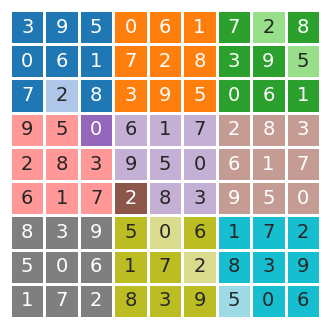

In [22]:
for gcd in reversed(range(333_667, 2*10**7, 333_667)):
    if solve(gcd):
        break